In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
SEED=3093453
np.random.seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [2]:


df = pd.DataFrame(columns = ["Set", "Filename", "raw"])


#for Set in ["A", "B", "C"]:
for Set in ["X", "X-DEBUG"]:
    path = os.path.join(cwd, "data", Set)
    for dirpath, dirnames, filenames in os.walk(path):
        filenames = sorted(filenames)
        for filename in filenames:
            if not filename.endswith(".out"):
                continue
            filepath = os.path.join(dirpath, filename)
            #print(filename)
            with open(filepath, "r") as f:
                raw_text = f.read()
            
            data = pd.DataFrame([[Set, filename[:-4], raw_text]], columns = ["Set", "Filename", "raw"])
            df = pd.concat([df, data])


#df = df[df.Filename.str.contains(r"[A-Z][A-Z]\d?\-\d{1,3}")]

df["Threshold"] = df["Filename"].str.extract("\-(\d*)").astype(float)
df["Instance"] = df["Filename"].str.split("-").str[0]
df = df.sort_values(["Set", "Filename"]).reset_index(drop=True)

df

,Set,Filename,raw,Threshold,Instance
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS
1,X,AS-0,"cpu-bind=MASK - cn-0142, task 0 0 [3234793]:...",0.0,AS
2,X,AS-10,"cpu-bind=MASK - cn-0140, task 0 0 [3622505]:...",10.0,AS
3,X,AS-100,"cpu-bind=MASK - cn-0100, task 0 0 [3560115]:...",100.0,AS
4,X,AS-20,"cpu-bind=MASK - cn-0206, task 0 0 [2294212]:...",20.0,AS
...,...,...,...,...,...
1795,X-DEBUG,VA6-80-DEBUG-2,"cpu-bind=MASK - cn-0059, task 0 0 [3526413]:...",80.0,VA6
1796,X-DEBUG,VA7,,NaN,VA7
1797,X-DEBUG,VA7-80-DEBUG-0,"cpu-bind=MASK - cn-0025, task 0 0 [567699]: ...",80.0,VA7
1798,X-DEBUG,VA7-80-DEBUG-1,"cpu-bind=MASK - cn-0025, task 0 0 [567700]: ...",80.0,VA7


In [3]:
df = df[(df["Set"] == "X")&(df["Threshold"].isnull()) | (df["Set"] == "X-DEBUG")&(~df["Threshold"].isnull())]

In [4]:
df["finalObjective"] = df.raw.str.extract("Final Solution\nObjective;(\d*\.?\d?)\nTransportation cost;").astype(float)
df["finalTransportationCost"] = df.raw.str.extract("Final Solution\nObjective;\d*\.?\d?\nTransportation cost;(\d*\.?\d?)").astype(float)
df["finalInventoryCost"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;(\d*\.?\d?)"
).astype(float)
df["Runtime"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;\d*\.?\d?\nRuntime;(\d*\.?\d?)"
).astype(float)
#df["finalObjective"].hist()

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_69535/505975397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["finalObjective"] = df.raw.str.extract("Final Solution\nObjective;(\d*\.?\d?)\nTransportation cost;").astype(float)
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_69535/505975397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["finalTransportationCost"] = df.raw.str.extract("Final Solution\nObjective;\d*\.?\d?\nTransportation cost;(\d*\.?\d?)").astype(float)
/v

In [5]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()

In [6]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()
#num_LNS_iterations.index.name=
num_LNS_iterations.name = "num_LNS_iter"
df = df.join(num_LNS_iterations)
df["num_LNS_iter"] = df["num_LNS_iter"].fillna(0).astype(int)

In [7]:
df.head()

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS,2017343.0,1942200.0,75143.0,3590.9,3
12,X,AS2,"cpu-bind=MASK - cn-0256, task 0 0 [978147]: ...",NaN,AS2,2173535.0,2043600.0,129935.0,3595.7,3
24,X,AS3,"cpu-bind=MASK - cn-0214, task 0 0 [2414625]:...",NaN,AS3,9809539.0,9706500.0,103039.0,3597.4,3
36,X,AS4,"cpu-bind=MASK - cn-0245, task 0 0 [3948989]:...",NaN,AS4,2048455.0,1975500.0,72955.0,3596.1,3
48,X,AS5,"cpu-bind=MASK - cn-0202, task 0 0 [588995]: ...",NaN,AS5,2217620.0,2084700.0,132920.0,3594.9,3


In [8]:
reference_df = df[df.Threshold.isnull()].copy()
df = df[~df.Threshold.isnull()].copy().reset_index(drop=True)
df["Threshold"] = df["Threshold"].astype(int)
df.head()

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X-DEBUG,AS4-0-DEBUG,"cpu-bind=MASK - cn-0210, task 0 0 [930141]: ...",0,AS4,2369198.0,2296800.0,72398.0,3595.7,1
1,X-DEBUG,AS4-10-DEBUG,"cpu-bind=MASK - cn-0211, task 0 0 [490089]: ...",10,AS4,2114382.0,2042100.0,72282.0,3596.2,2
2,X-DEBUG,AS4-100-DEBUG,"cpu-bind=MASK - cn-0220, task 0 0 [3337837]:...",100,AS4,1957306.0,1883400.0,73906.0,2672.3,13
3,X-DEBUG,AS4-20-DEBUG,"cpu-bind=MASK - cn-0212, task 0 0 [3285203]:...",20,AS4,2052212.0,1978200.0,74012.0,3432.5,3
4,X-DEBUG,AS4-30-DEBUG,"cpu-bind=MASK - cn-0213, task 0 0 [926131]: ...",30,AS4,1977866.0,1905000.0,72866.0,3432.5,9


In [9]:
print(reference_df[reference_df.Instance == "TA4"]["raw"].item())

cpu-bind=MASK - cn-0128, task  0  0 [3792918]: mask |--------------------||||--------BBBBBBBB----|  set
Python 3.10.6
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)
Copyright (c) 2022, Gurobi Optimization, LLC
started at Sun Jan 14 16:13:55 CET 2024
####################################################################################################
####################################################################################################
Start ROADEF
Set parameter TokenServer to value "license3.uni-paderborn.de"
Solve instance TA4 with a warm start and tight groups.
####################################################################################################
####################################################################################################
Time for optimization 3600.0 (s)
####################################################################################################
Data read
Took 	00:00:00.839
########################################

In [10]:
df = df.merge(
    reference_df[["Set", "Instance", "finalTransportationCost", "finalInventoryCost", "finalObjective", "Runtime", "num_LNS_iter"]],
    how="left",
    on=[#"Set",
        "Instance"],
    suffixes=("", "_Reference"),
    
)
df.head()

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,Set_Reference,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference
0,X-DEBUG,AS4-0-DEBUG,"cpu-bind=MASK - cn-0210, task 0 0 [930141]: ...",0,AS4,2369198.0,2296800.0,72398.0,3595.7,1,X,1975500.0,72955.0,2048455.0,3596.1,3
1,X-DEBUG,AS4-10-DEBUG,"cpu-bind=MASK - cn-0211, task 0 0 [490089]: ...",10,AS4,2114382.0,2042100.0,72282.0,3596.2,2,X,1975500.0,72955.0,2048455.0,3596.1,3
2,X-DEBUG,AS4-100-DEBUG,"cpu-bind=MASK - cn-0220, task 0 0 [3337837]:...",100,AS4,1957306.0,1883400.0,73906.0,2672.3,13,X,1975500.0,72955.0,2048455.0,3596.1,3
3,X-DEBUG,AS4-20-DEBUG,"cpu-bind=MASK - cn-0212, task 0 0 [3285203]:...",20,AS4,2052212.0,1978200.0,74012.0,3432.5,3,X,1975500.0,72955.0,2048455.0,3596.1,3
4,X-DEBUG,AS4-30-DEBUG,"cpu-bind=MASK - cn-0213, task 0 0 [926131]: ...",30,AS4,1977866.0,1905000.0,72866.0,3432.5,9,X,1975500.0,72955.0,2048455.0,3596.1,3


In [11]:
df["Subset"] = "Training"
df.loc[(df.Set.str.contains("X")) & (df.Instance.str.endswith("4") | df.Instance.str.endswith("5")), "Subset"] = "Validation"
df.loc[(df.Set.str.contains("X")) & (df.Instance.str.endswith("6") | df.Instance.str.endswith("7")), "Subset"] = "Testing"

In [12]:
df = df[(df["Subset"] == "Testing")]

In [13]:
clms = df.columns

for clm in clms[clms.str.contains("_Reference")]:
    clm_clean = clm.split("_Reference")[0]
    if df[clm].dtype == "O":
        continue
    df[clm_clean] = df[clm_clean] / df[clm]

df.head()

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,Set_Reference,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference,Subset
28,X-DEBUG,AS6-80-DEBUG-0,"cpu-bind=MASK - cn-0066, task 0 0 [2405832]:...",80,AS6,0.946403,0.946127,0.970001,0.744314,4.000000,X,9856500.0,115170.0,9971670.0,3455.8,3,Testing
29,X-DEBUG,AS6-80-DEBUG-1,"cpu-bind=MASK - cn-0067, task 0 0 [3492094]:...",80,AS6,0.942198,0.941866,0.970652,0.742578,3.333333,X,9856500.0,115170.0,9971670.0,3455.8,3,Testing
30,X-DEBUG,AS6-80-DEBUG-2,"cpu-bind=MASK - cn-0068, task 0 0 [4031986]:...",80,AS6,0.943413,0.942931,0.984657,0.761531,4.333333,X,9856500.0,115170.0,9971670.0,3455.8,3,Testing
31,X-DEBUG,AS7-80-DEBUG-0,"cpu-bind=MASK - cn-0255, task 0 0 [2374124]:...",80,AS7,0.960308,0.959168,0.992119,0.929643,5.000000,X,1947000.0,69788.0,2016788.0,3580.3,3,Testing
32,X-DEBUG,AS7-80-DEBUG-1,"cpu-bind=MASK - cn-0255, task 0 0 [2374142]:...",80,AS7,0.954395,0.952234,1.014687,0.902969,4.333333,X,1947000.0,69788.0,2016788.0,3580.3,3,Testing


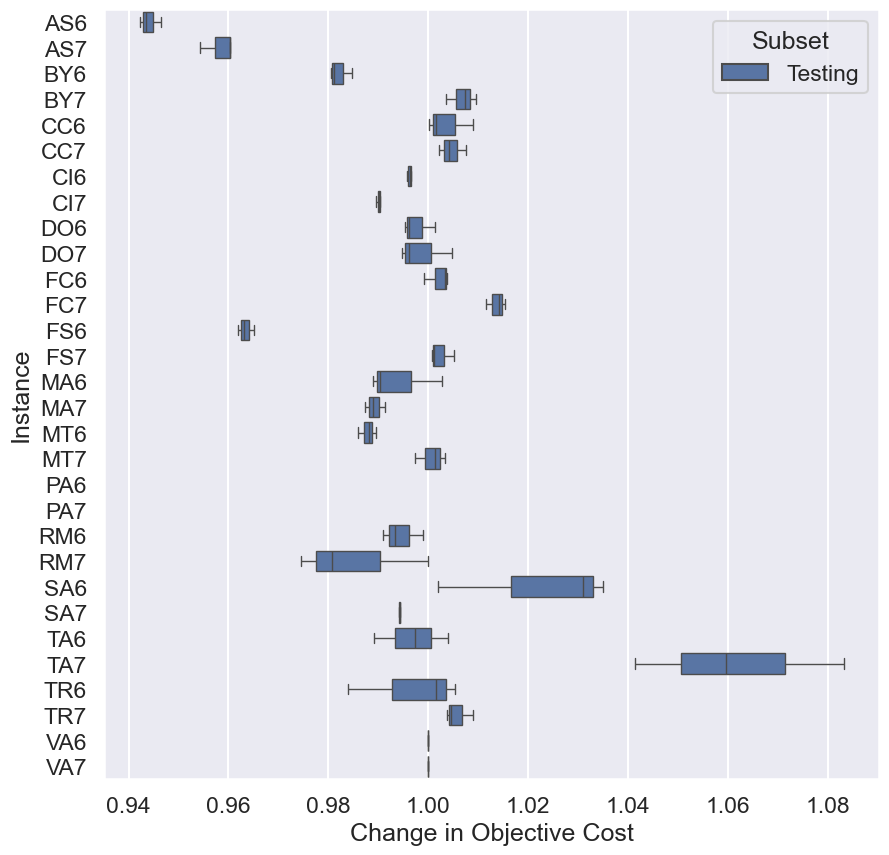

In [14]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

In [15]:
df["finalObjective"].isnull().mean()
df["finalObjective"].isnull().sum()

6

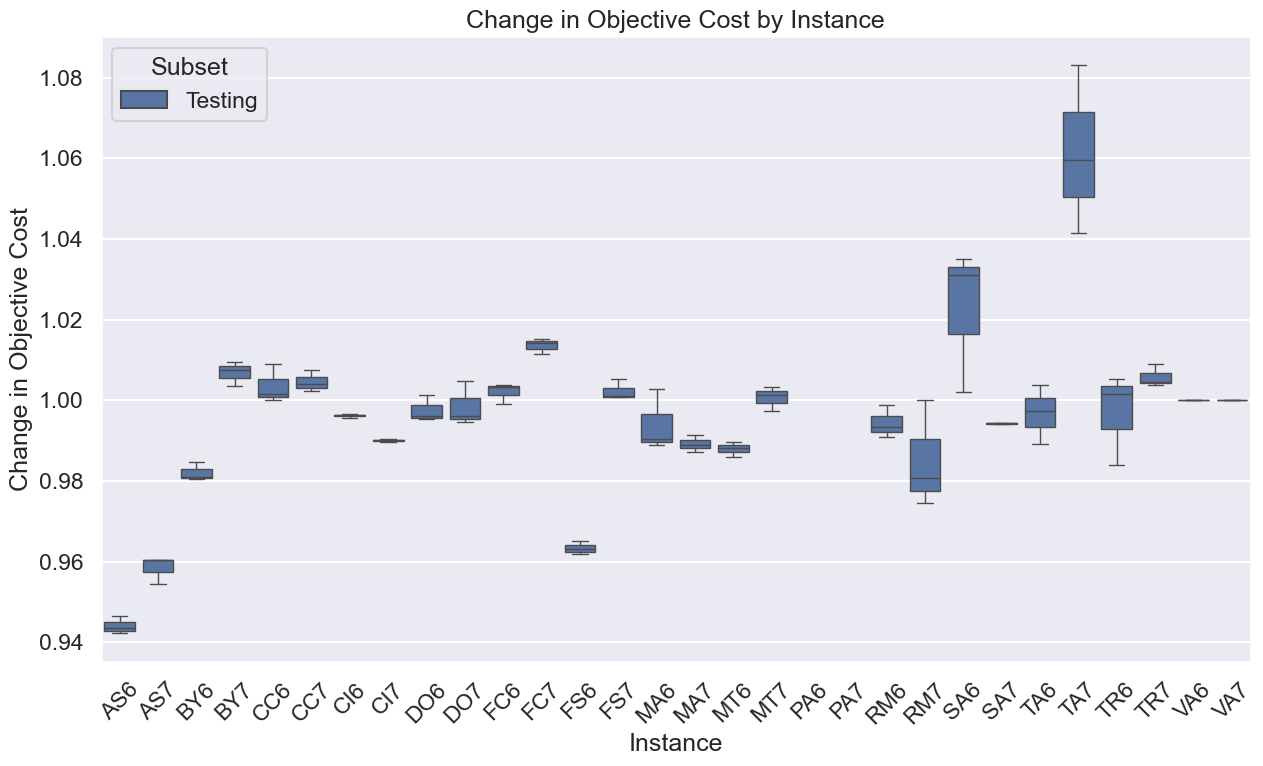

In [39]:
plt.figure(figsize=(13, 8))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, x="Instance", y="finalObjective", hue="Subset");
plt.ylabel("Change in Objective Cost");
plt.title("Change in Objective Cost by Instance");
plt.xticks(rotation=45);

plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-16-ExperimentsTest-80", f"Change in Objective by Instance.{file_format}")
    plt.savefig(path)


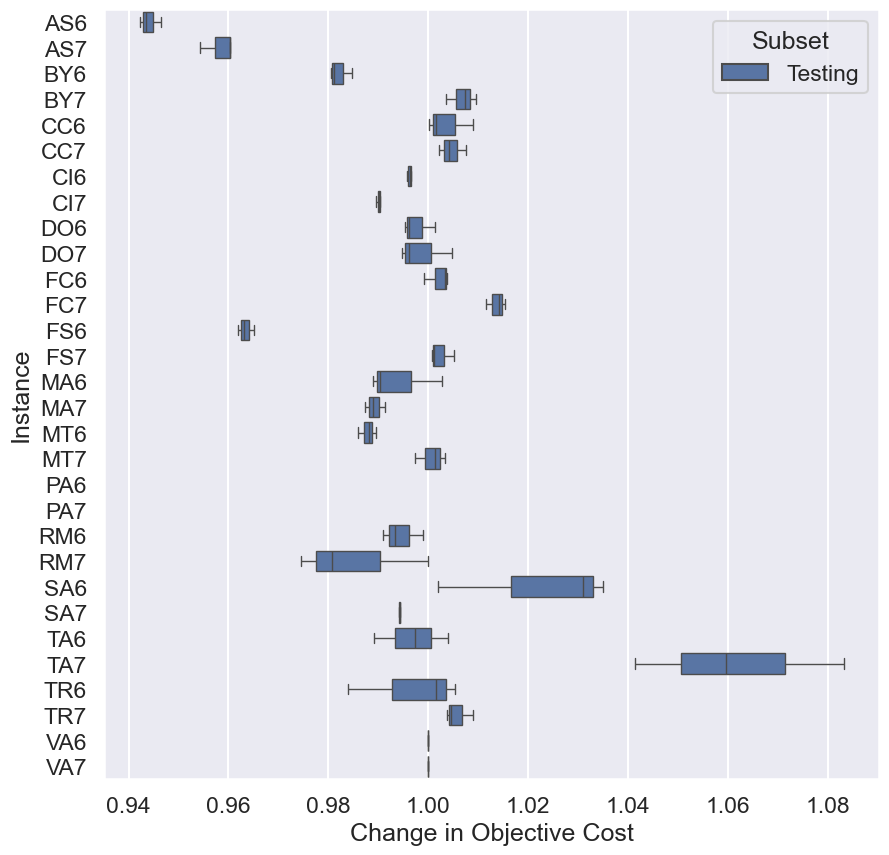

In [17]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

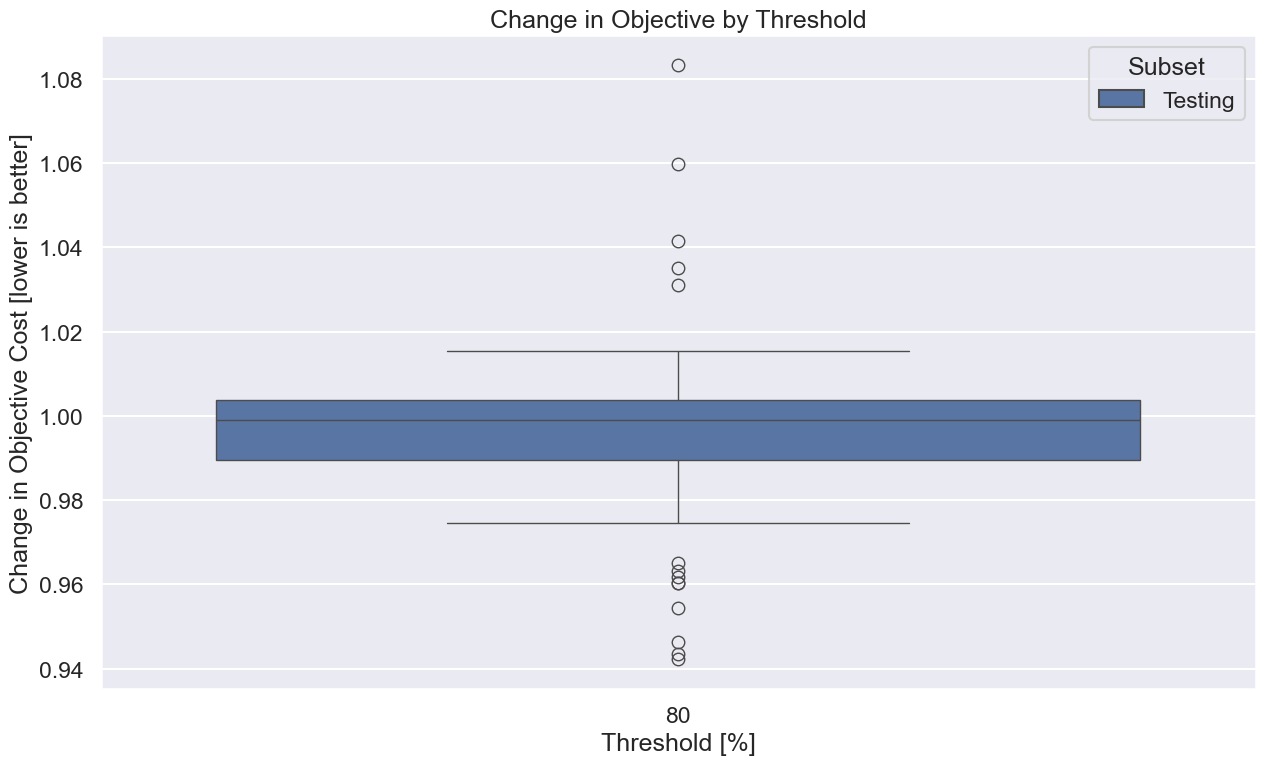

In [18]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=df, y="finalObjective", x="Threshold", hue="Subset");
plt.xlabel("Threshold [%]")
plt.ylabel("Change in Objective Cost [lower is better]");
plt.title("Change in Objective by Threshold")

plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-12-ExperimentsThreshold-DEBUG", f"Change in Objective by Threshold.{file_format}")
    plt.savefig(path)


In [19]:
df.groupby("Threshold")[["finalObjective"]].agg(["mean", "std", "count"])

finalObjective                
                    mean       std count
Threshold                               
80              0.996156  0.021127    84

In [29]:
from scipy.stats import norm, t

t_value = (0.996156-1) /(0.021127/84**0.5)
print(t_value)

t.cdf(t_value, df=29-1)

-1.667574286118243


0.05327404087250511

In [31]:
x = df.finalObjective[df.Threshold == 80]
x = x[~x.isnull()]

t_value = (1-x.mean()) / x.std() * len(x)**0.5
t_value

1.667574210340273

In [32]:
from scipy.stats import t

t.pdf(t_value, df=len(x)-1)

0.09965456377970631

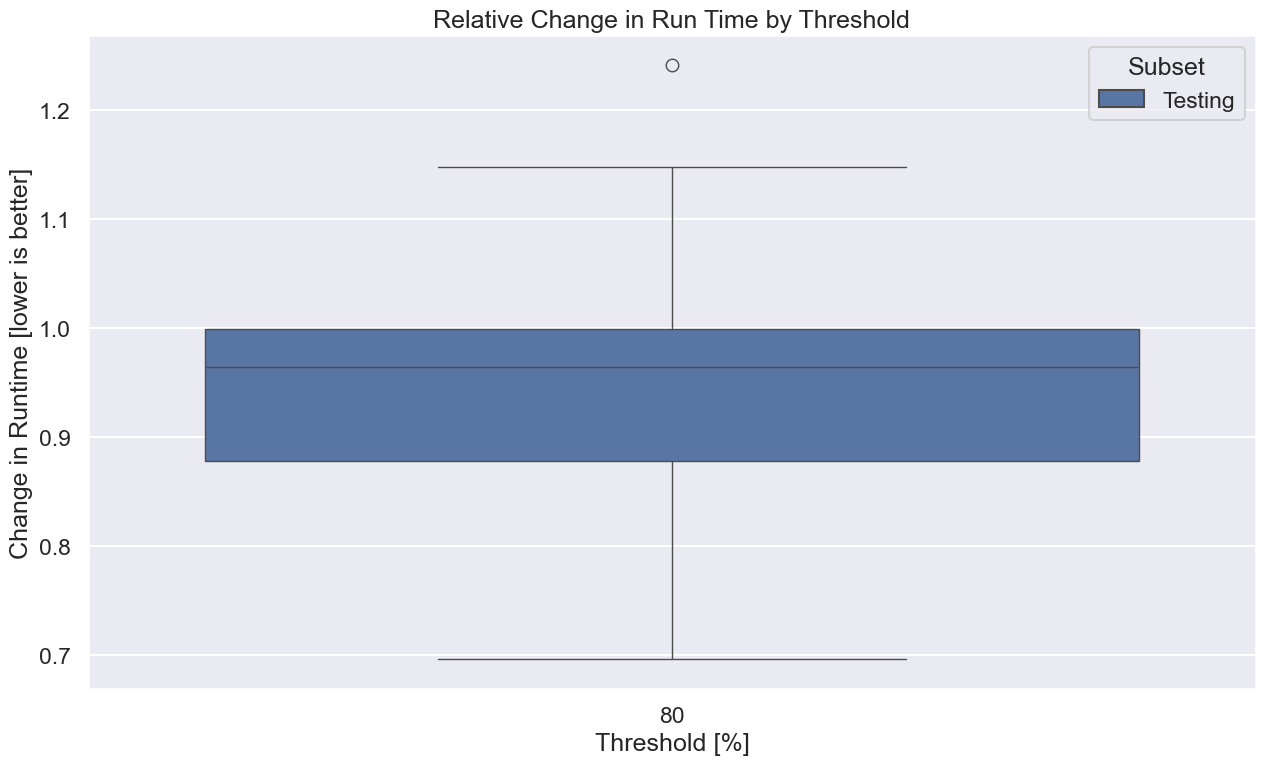

In [33]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=df, y="Runtime", x="Threshold", hue="Subset");
plt.xlabel("Threshold [%]")
plt.ylabel("Change in Runtime [lower is better]");
plt.title("Relative Change in Run Time by Threshold")


plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-12-ExperimentsThreshold-DEBUG", f"Change in Runtime by Threshold VALIDATION.{file_format}")
    plt.savefig(path)

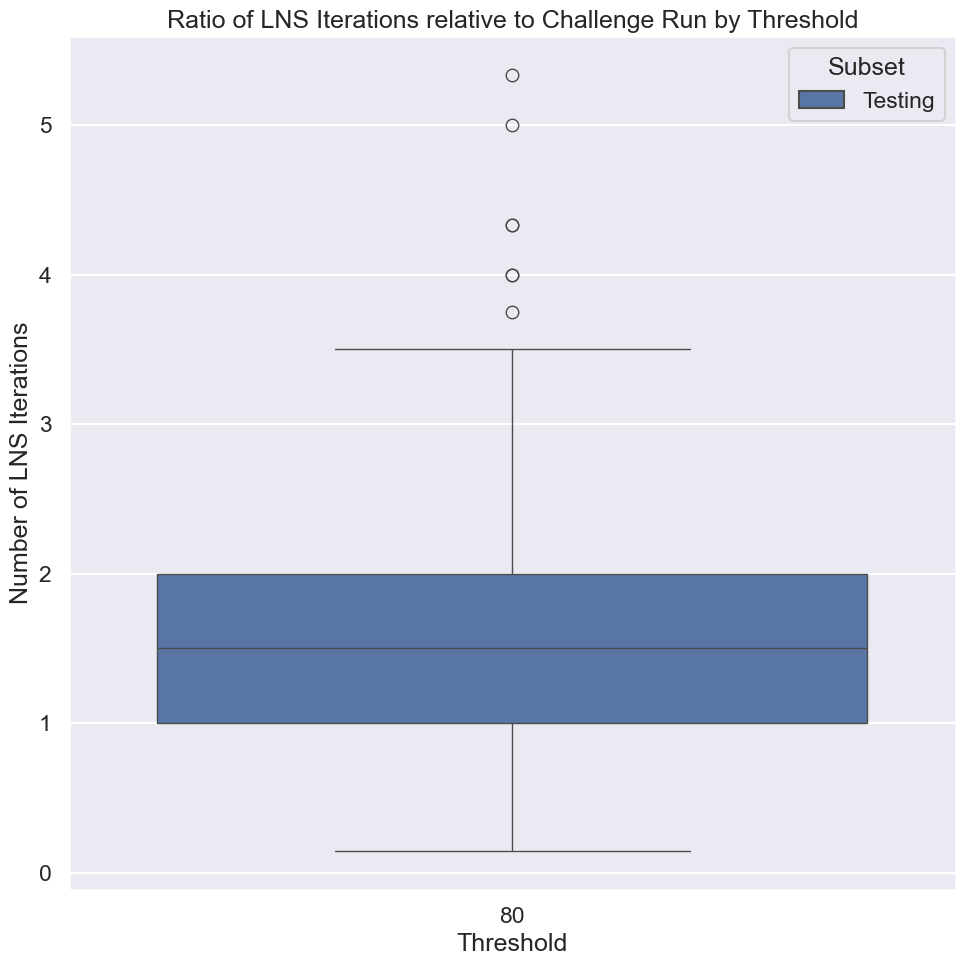

In [34]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="num_LNS_iter", x="Threshold", hue="Subset");
plt.ylabel("Number of LNS Iterations");
plt.title("Ratio of LNS Iterations relative to Challenge Run by Threshold");
plt.tight_layout()

In [35]:
reference_df[(reference_df.Set == "A")&(reference_df.Instance == "BU")]

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter


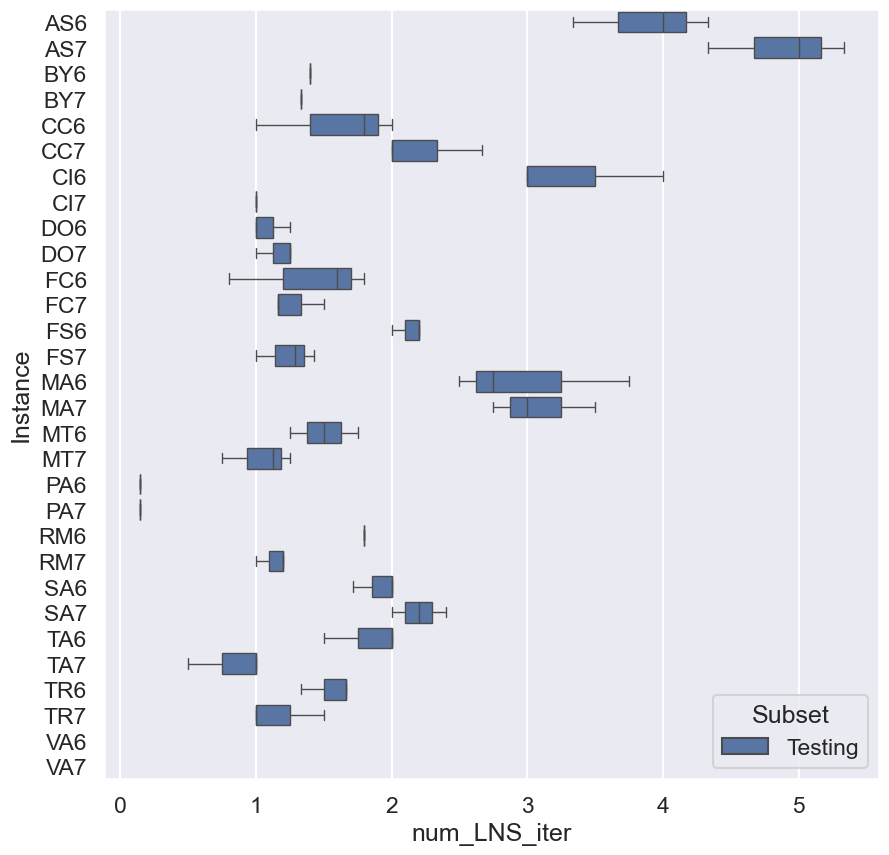

In [36]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="Instance", x="num_LNS_iter", hue="Subset");
#plt.ylabel("Change in Runtime");

## Crosstable Model / Area

In [37]:
idx = df[(df.Instance == "TA4")& (df.Threshold==80)].index.item()

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
tab = (
    df["raw"]
    .str.extractall("Model Prediction: (\d\.\d*)-Neuer Approach: .*?\n-Packed Area\s*:(\d\.\d*)-Alter Approach:")
    .astype(float)
    .reset_index()
    .drop("match", axis=1)
    .rename({
        "level_0": "Instance",
        0: "Prediction",
        1: "AreaRatio",
    },axis=1)
)
tab.head()

In [ ]:
sub_tab = tab.loc[tab.Instance == idx]

fig, ax = plt.subplots(2, figsize=(10, 10))

sns.histplot(data=sub_tab, x="Prediction", bins=np.arange(-0.1, 1.1, 0.05),ax=ax[0]);
sns.histplot(data=sub_tab, x="AreaRatio", bins=np.arange(-0.1, 1.1, 0.05),ax=ax[1]);

ax[0].set(ylabel="Prediction", xlim=[0, 1])
ax[1].set(ylabel="AreaRation", xlim=[0, 1]);

plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-12-ExperimentsThreshold-DEBUG", f"TA4-Prediction+AreaRatio.{file_format}")
    plt.savefig(path)
    pass

In [ ]:
sns.scatterplot(data=sub_tab, x="AreaRatio", y="Prediction", alpha=0.5);

In [ ]:
crosstab = pd.crosstab((sub_tab["Prediction"] > 0.8), (sub_tab["AreaRatio"] < .9))
crosstab[True] = 0
crosstab

In [ ]:
crosstab = pd.crosstab((tab["Prediction"] > 0.8), (tab["AreaRatio"] < .9), normalize=True)
(crosstab*100).round(1)

In [ ]:
stacks = df["raw"].str.extractall("\nStack (\d*) with items:")\
    .reset_index()\
    .set_index("level_0")\
    .astype({0: int})
stacks

In [ ]:
stack_counts = stacks[0].value_counts().sort_index(ascending=True).diff(-1)

#plt.bar(stack_counts.index, stack_counts);
stack_counts#.index.max()

In [ ]:
prediction_times = (
    df["raw"]
    .str.extractall("Time spent for prediction: (\d\.\d*) for Batch of (\d*) truck plans")
    .reset_index()
    .rename({"level_0": "Instance",
             "match": "LNS-Iteration",
             0: "InferenceTime",
             1: "numTrucks"},
            axis=1)
    .astype({"InferenceTime": float,
             "numTrucks": int})
)

TA4_index = df[df.Instance=="TA4"].index

prediction_times[ np.isin(prediction_times.Instance, TA4_index)]

sns.regplot(
    data = prediction_times[ np.isin(prediction_times.Instance, TA4_index)],
    x = "numTrucks",
    y = "InferenceTime",
    #logx=True
)
plt.xlabel("Number of Trucks")
plt.ylabel("Inference Time [s]");
plt.title("Inference Time by Truck count for Instance X-TA4");

plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-12-ExperimentsThreshold-DEBUG", f"TA4-InferenceTime.{file_format}")
    plt.savefig(path)
    pass

In [ ]:
sns.regplot(data=df.loc[TA4_index], x="Threshold", y="finalObjective");
#sns.regplot(data=df.loc[TA4_index], x="Threshold", y="finalTransportationCost");
#sns.regplot(data=df.loc[TA4_index], x="Threshold", y="finalInventoryCost");

plt.xlabel("Threshold [%]")
#plt.ylabel("Inference Time [s]");
plt.title("Final Objective by Threshold for Instance X-TA4");


plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-12-ExperimentsThreshold-DEBUG", f"TA4-ObjectiveByThreshold.{file_format}")
    plt.savefig(path)
    pass

In [ ]:
print(df.loc[TA4_index]["raw"][274])

In [ ]:
sns.regplot(data=df.loc[TA4_index], x="Threshold", y="num_LNS_iter");
plt.ylabel("LNS Iterations")
plt.title("Number of LNS Iterations by Threshold\ncompared to TA4 (5 Iterations)")

plt.tight_layout()
for file_format in ["pdf"]:
    path = os.path.join(cwd, "plots", "2024-04-12-ExperimentsThreshold-DEBUG", f"TA4-LNS_IterByThreshold.{file_format}")
    plt.savefig(path)
    pass

In [ ]:
df

### Compare the number of LNS-Iterations

In [ ]:
LNS_iter_times_reference = (
    reference_df[reference_df.Instance == "TA4"]["raw"]
    .str.extractall("numTrucksRepack:\s*\d*\nRemaining Time:\s*(\d*\.\d*)")
    .astype(float)
    .diff(-1)
)
LNS_iter_times_reference

In [ ]:
LNS_iter_times = (
    df[df.Instance == "TA4"]["raw"]
    .str.extractall("numTrucksRepack:\s*\d*\nRemaining Time:\s*(\d*\.\d*)")
    .astype(float)
    .diff(-1)
)
LNS_iter_times[LNS_iter_times[0]<0] = np.nan
LNS_iter_times.head(7)

In [ ]:

#LNS_iter_times_reference[LNS_iter_times_reference[0]<0] = np.nan

fig, ax = plt.subplots(figsize=(13, 8))
LNS_iter_times.hist(ax=ax, bins=np.arange(0, 750, 50))
LNS_iter_times_reference.hist(ax=ax, bins=np.arange(0, 750, 50))

In [ ]:
LNS_iter_times_reference

In [ ]:
#LNS_iter_times = LNS_iter_times.dropna().reset_index().set_index("level_0").merge(df[["Threshold"]], left_index=True, right_index=True)

LNS_iter_times.groupby("match")[[0]].mean()

In [ ]:
LNS_iter_times[LNS_iter_times.Threshold > 50]

In [ ]:
prediction_times.groupby("Instance")["LNS-Iteration"].max().hist(bins=np.arange(0, 22, 1)-0.5);
plt.xlabel("Number of LNS-Iterations");

In [ ]:
print(df["raw"][0])